In [13]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('ggplot')

%matplotlib inline

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [3]:
def save_model(classifier, stage, dataset, model_type, hz):
    '''
        Saves model to defined folder.

        stage - baseline/optimized
        dataset - base/centered/end/etc
        model_types - decision_tree, random_forest, ...
        hz - frequency
    '''

    import os
    import m2cgen as m2c
    
    BASE_PATH = f'models/{stage}/{dataset}/{model_type}/'
    FILE_NAME = f'{model_type}_{hz}hz.py'

    if not os.path.exists(BASE_PATH):
        os.makedirs(BASE_PATH)

    code = m2c.export_to_python(classifier)
    with open(BASE_PATH + FILE_NAME, 'w') as f:
        f.writelines(code)

In [5]:
def trainer_helper(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')

    return accuracy, f1, precision, recall, clf

In [25]:
def get_df_base(df):
    df = df[(df['shift'] == 0)]
    return df.dropna(axis=0)

def get_df_center(df):
    df = df[
            ((df['label'] == 1) & (df['shift'] == -20))
            | ((df['label'] == 2) & (df['shift'] == -20))
            | ((df['label'] == 3) & (df['shift'] == 0))
            | ((df['label'] == 0) & (df['shift'] == 0))
        ]
    return df.dropna(axis=0)

def get_df_center_aug(df):
    df = df[
            ((df['label'] == 1) & (df['shift'] <= -15))
            | ((df['label'] == 2) & (df['shift'] <= -15))
            | ((df['label'] == 3) & (df['shift'] == -2))
            | ((df['label'] == 3) & (df['shift'] == -1))
            | ((df['label'] == 3) & (df['shift'] == 0))
            | ((df['label'] == 3) & (df['shift'] == 1))
            | ((df['label'] == 3) & (df['shift'] == 2))
            | ((df['label'] == 0) & (df['shift'] > 1))
        ]
    return df.dropna(axis=0)

def get_df_end(df):
    df = df[
            ((df['label'] == 1) & (df['shift'] == -37))
            | ((df['label'] == 2) & (df['shift'] == -37))
            | ((df['label'] == 3) & (df['shift'] == 0))
            | ((df['label'] == 0) & (df['shift'] == 0))
        ]
    return df.dropna(axis=0)

In [7]:
def run_training(X_train,X_test, y_train, y_test, stage, dataset, hz, collect_time=False, is_save_model=False):
    collect_metrics = {}

    dt = DecisionTreeClassifier(random_state=42)
    rf = RandomForestClassifier(random_state=42, n_estimators=4)
    lsvc = LinearSVC(random_state=42, max_iter=10_000)
    lr = LogisticRegression(random_state=42, max_iter=10_000)

    model_setup = [
                    (dt, 'decision_tree'),
                    (rf,'random_forest'),
                    (lsvc, 'svc'),
                    (lr, 'logistic_regression')
                ]

    for item in model_setup:
        clf = item[0]
        name = item[1]

        collect_metrics[name] = {}

        print('\n')
        print(f'{name} {hz} Hz')

        accuracy, f1, precision, recall, model = trainer_helper(clf, X_train, X_test, y_train, y_test)

        collect_metrics[name] = {
                'accuracy':accuracy,
                'f1':f1,
                'precision':precision,
                'recall':recall}

        if collect_time:
            test_data = [X_train.iloc[0]]
            inf_time = get_ipython().run_line_magic('timeit', '-o model.predict(test_data)')
            collect_metrics[name]['time'] = inf_time.timings

        if is_save_model:
            save_model(model, stage, dataset, name, hz)

    return collect_metrics

In [9]:
res = {}

for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = get_df_base(df)
    df_train = df_train.dropna(axis=0)


    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)

    results = run_training(
                    X_train, X_test, y_train, y_test,
                    stage='baseline',
                    dataset='base',
                    hz=hz,
                    collect_time=True,
                    is_save_model=True
                    )

    res[hz] = results


Training on dataset with 10 Hz
**************************************************


DF Shape (228, 68)


decision_tree 10 Hz
67.6 µs ± 3.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


random_forest 10 Hz
596 µs ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


svc 10 Hz
57.3 µs ± 439 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


logistic_regression 10 Hz
57.8 µs ± 603 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Training on dataset with 20 Hz
**************************************************


DF Shape (228, 128)


decision_tree 20 Hz
64.8 µs ± 530 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


random_forest 20 Hz
590 µs ± 6.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


svc 20 Hz
58.3 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


logistic_regression 20 Hz
58.6 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Training on dataset with 25 Hz
******

In [10]:
res_df = pd.DataFrame(res)
res_df_acc.to_csv('output/baseline_base_dataset_results.csv', index=False)

res_df_acc = res_df.applymap(lambda x: x['accuracy'])
res_df_acc = res_df_acc.T.reset_index()
res_df_acc = res_df_acc.melt(id_vars=['index']).rename(columns={'variable':'model','value':'accuracy','index':'hz'})
res_df_acc.to_csv('output/baseline_results/baseline_model_accuracy.csv', index=False)

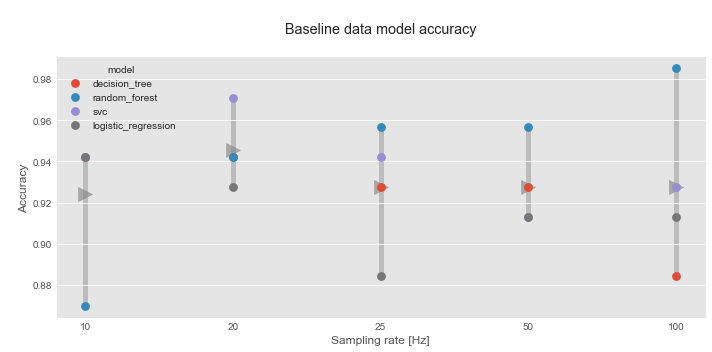

In [70]:
plt.figure(figsize=(10,5))
res_df_acc = pd.read_csv('output/baseline_model_accuracy.csv')

sns.pointplot(data=res_df_acc, x='hz', y='accuracy', hue='model', marker='o', linestyles='', zorder=10)
plt.title('\nBaseline data model accuracy\n');
plt.ylabel('\nAccuracy')
plt.xlabel('Sampling rate [Hz]')

for x in [(0,10), (1,20), (2,25), (3,50), (4, 100)]:
    plt.vlines(
        x=x[0], 
        ymin=res_df_acc[res_df_acc['hz'] == x[1]]['accuracy'].min(), 
        ymax=res_df_acc[res_df_acc['hz'] == x[1]]['accuracy'].max(), 
        color='grey', 
        alpha=0.4,
        zorder=0,
        linewidth=5)
    plt.scatter(
        x=x[0],
        y=res_df_acc[res_df_acc['hz'] == x[1]]['accuracy'].mean(),
        marker='>',
        zorder=0,
        s=200,
        color='grey',
        alpha=0.6
    )

plt.tight_layout()

In [29]:
data = pd.read_csv('output/baseline_model_accuracy.csv')
data[data['hz'] == 10]['accuracy'].min()

0.8695652173913043

In [12]:
from models.baseline.base.decision_tree import decision_tree_10hz, decision_tree_20hz, decision_tree_25hz, decision_tree_50hz, decision_tree_100hz
from models.baseline.base.random_forest import random_forest_10hz, random_forest_20hz, random_forest_25hz, random_forest_50hz, random_forest_100hz
from models.baseline.base.svc import svc_10hz, svc_20hz, svc_25hz, svc_50hz, svc_100hz
from models.baseline.base.logistic_regression import logistic_regression_10hz, logistic_regression_20hz, logistic_regression_25hz, logistic_regression_50hz, logistic_regression_100hz


In [13]:
test_data_10hz = pd.read_csv('data/transformed/20210529_v2_data_all_10hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_20hz = pd.read_csv('data/transformed/20210529_v2_data_all_20hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_25hz = pd.read_csv('data/transformed/20210529_v2_data_all_25hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_50hz = pd.read_csv('data/transformed/20210529_v2_data_all_50hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_100hz = pd.read_csv('data/transformed/20210529_v2_data_all_100hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]


In [14]:
test_data_10hz.shape, test_data_20hz.shape, test_data_25hz.shape, test_data_50hz.shape, test_data_100hz.shape


((66,), (126,), (156,), (306,), (606,))

In [15]:
from statistics import mean

m2c_time_test_setup = {
    'decision_tree': [
        (decision_tree_10hz, test_data_10hz, 10),
        (decision_tree_20hz, test_data_20hz, 20),
        (decision_tree_25hz, test_data_25hz, 25),
        (decision_tree_50hz, test_data_50hz, 50),
        (decision_tree_100hz, test_data_100hz, 100)
    ],
    'random_forest': [
        (random_forest_10hz, test_data_10hz, 10),
        (random_forest_20hz, test_data_20hz, 20),
        (random_forest_25hz, test_data_25hz, 25),
        (random_forest_50hz, test_data_50hz, 50),
        (random_forest_100hz, test_data_100hz, 100)
    ],
    'svc': [
        (svc_10hz, test_data_10hz, 10),
        (svc_20hz, test_data_20hz, 20),
        (svc_25hz, test_data_25hz, 25),
        (svc_50hz, test_data_50hz, 50),
        (svc_100hz, test_data_100hz, 100)
    ],
    'logistic_regression': [
        (logistic_regression_10hz, test_data_10hz, 10),
        (logistic_regression_20hz, test_data_20hz, 20),
        (logistic_regression_25hz, test_data_25hz, 25),
        (logistic_regression_50hz, test_data_50hz, 50),
        (logistic_regression_100hz, test_data_100hz, 100)
    ]
}

m2c_time_data = {}            

for k, v in m2c_time_test_setup.items():
    m2c_time_data[k] = {}
    for t_item in v:
        model = t_item[0]
        test_data = t_item[1]
        freq = t_item[2]
        res_time = get_ipython().run_line_magic('timeit', '-o model.score(test_data)')

        m2c_time_data[k][freq] = mean(res_time.timings)

6.48 µs ± 74.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.89 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.77 µs ± 17.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.79 µs ± 28.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.24 µs ± 12.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
29.9 µs ± 223 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
31.7 µs ± 669 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
28 µs ± 847 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
32.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
26.6 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
457 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
852 µs ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.04 ms ± 39.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.09 ms ± 70.5 µs per loop (mean ± std. dev. o

In [16]:
m2c_time_df = pd.DataFrame(m2c_time_data)
skl_time_df = res_df.applymap(lambda x: mean(x['time'])).T

In [17]:
m2c_time_df['framework'] = 'pure-python'
skl_time_df['framework'] = 'scikit'
inf_time_df = pd.concat([m2c_time_df, skl_time_df]).reset_index().rename(columns={'index':'hz'})
inf_time_df.to_csv('output/baseline_results/baseline_model_inference_time.csv', index=False)


In [97]:

inf_t_dt[inf_t_dt['hz'] == 10]

,hz,decision_tree,framework
0,10,0.006476,pure-python
5,10,0.067574,scikit


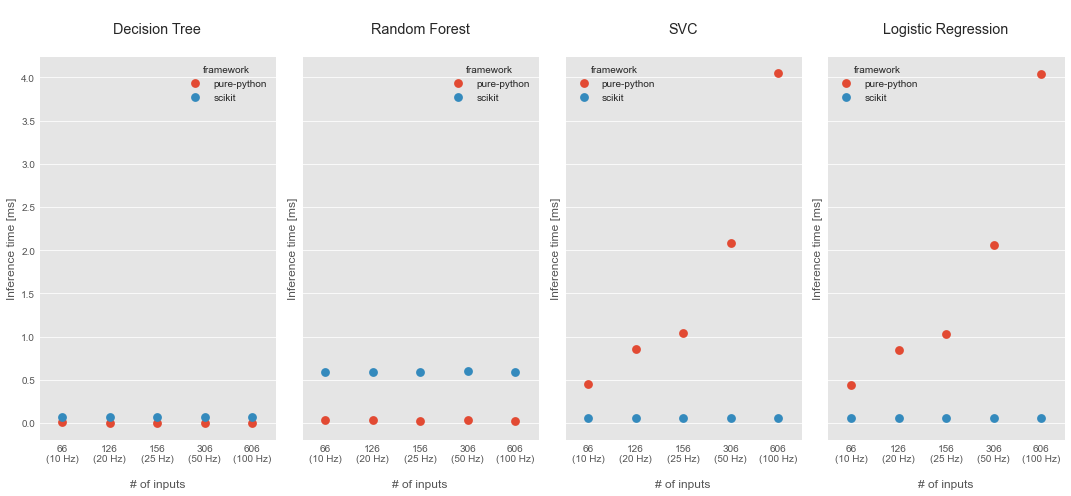

In [119]:
import matplotlib.ticker as tick

# load data
inf_time_df = pd.read_csv('output/baseline_model_inference_time.csv')
inf_time_df[['decision_tree', 'random_forest','svc','logistic_regression']] = inf_time_df[['decision_tree', 'random_forest','svc','logistic_regression']] * 1000

inf_t_dt = inf_time_df[['hz','decision_tree','framework']].rename(columns={'decision_tree':'time'})
inf_t_rf = inf_time_df[['hz','random_forest','framework']].rename(columns={'random_forest':'time'})
inf_t_svc = inf_time_df[['hz','svc','framework']].rename(columns={'svc':'time'})
inf_t_lr = inf_time_df[['hz','logistic_regression','framework']].rename(columns={'logistic_regression':'time'})

fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(15,7))
plt.title('Inference times')

for i , data in enumerate([inf_t_dt, inf_t_rf, inf_t_svc, inf_t_lr]):
    sns.pointplot(x='hz', y='time', hue='framework', data=data, ax=ax[i], linestyles='')
    
#     for x in [(0,10),(1,20), (2, 25), (3,50), (4,100)]:
#         ax[i].vlines(
#                 x=x[0], 
#                 ymin=data[data['hz'] == x[1]]['time'].min(), 
#                 ymax=data[data['hz'] == x[1]]['time'].max(), 
#                 color='grey', 
#                 alpha=0.4,
#                 zorder=0,
#                 linewidth=5)

    
for i, clf in enumerate(['Decision Tree', 'Random Forest', 'SVC', 'Logistic Regression']):
    ax[i].title.set_text(f'\n{clf}\n')
    ax[i].set_ylabel('Inference time [ms]')
    ax[i].set_xticklabels(['66\n(10 Hz)', '126\n(20 Hz)', '156\n(25 Hz)', '306\n(50 Hz)', '606\n(100 Hz)'])
    ax[i].set_xlabel('\n# of inputs')
    


# plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x, post: f'{(x * 1000)}'))
plt.tight_layout()

## Train data on centered dataset

In [26]:
res = {}

DATASET='centered'
DATASET_FUNC = get_df_center


for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = DATASET_FUNC(df)

    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)

    results = run_training(
                    X_train, X_test, y_train, y_test,
                    stage='baseline',
                    dataset=DATASET,
                    hz=hz,
                    collect_time=False,
                    is_save_model=True
                    )

    res[hz] = results

res_df = pd.DataFrame(res)
res_df.to_csv(f'output/baseline_results/baseline_{DATASET}_dataset_results.csv', index=False)


Training on dataset with 10 Hz
**************************************************


DF Shape (228, 68)


decision_tree 10 Hz


random_forest 10 Hz


svc 10 Hz


logistic_regression 10 Hz

Training on dataset with 20 Hz
**************************************************


DF Shape (228, 128)


decision_tree 20 Hz


random_forest 20 Hz


svc 20 Hz


logistic_regression 20 Hz

Training on dataset with 25 Hz
**************************************************


DF Shape (228, 158)


decision_tree 25 Hz


random_forest 25 Hz


svc 25 Hz


logistic_regression 25 Hz

Training on dataset with 50 Hz
**************************************************


DF Shape (228, 308)


decision_tree 50 Hz


random_forest 50 Hz


svc 50 Hz


logistic_regression 50 Hz

Training on dataset with 100 Hz
**************************************************


DF Shape (228, 608)


decision_tree 100 Hz


random_forest 100 Hz


svc 100 Hz


logistic_regression 100 Hz


In [27]:
res = {}

DATASET='centered_aug'
DATASET_FUNC = get_df_center_aug


for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = DATASET_FUNC(df)

    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)

    results = run_training(
                    X_train, X_test, y_train, y_test,
                    stage='baseline',
                    dataset=DATASET,
                    hz=hz,
                    collect_time=False,
                    is_save_model=True
                    )

    res[hz] = results

res_df = pd.DataFrame(res)
res_df.to_csv(f'output/baseline_results/baseline_{DATASET}_dataset_results.csv', index=False)


Training on dataset with 10 Hz
**************************************************


DF Shape (1112, 68)


decision_tree 10 Hz


random_forest 10 Hz


svc 10 Hz
/Users/tk/opt/miniconda3/envs/tinyml/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


logistic_regression 10 Hz

Training on dataset with 20 Hz
**************************************************


DF Shape (1112, 128)


decision_tree 20 Hz


random_forest 20 Hz


svc 20 Hz
/Users/tk/opt/miniconda3/envs/tinyml/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


logistic_regression 20 Hz

Training on dataset with 25 Hz
**************************************************


DF Shape (1112, 158)


decision_tree 25 Hz


random_forest 25 Hz


s

In [28]:
res = {}

DATASET='end'
DATASET_FUNC = get_df_end


for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = DATASET_FUNC(df)

    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)

    results = run_training(
                    X_train, X_test, y_train, y_test,
                    stage='baseline',
                    dataset=DATASET,
                    hz=hz,
                    collect_time=False,
                    is_save_model=True
                    )

    res[hz] = results

res_df = pd.DataFrame(res)
res_df.to_csv(f'output/baseline_results/baseline_{DATASET}_dataset_results.csv', index=False)


Training on dataset with 10 Hz
**************************************************


DF Shape (228, 68)


decision_tree 10 Hz


random_forest 10 Hz


svc 10 Hz
/Users/tk/opt/miniconda3/envs/tinyml/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


logistic_regression 10 Hz

Training on dataset with 20 Hz
**************************************************


DF Shape (228, 128)


decision_tree 20 Hz


random_forest 20 Hz


svc 20 Hz


logistic_regression 20 Hz

Training on dataset with 25 Hz
**************************************************


DF Shape (228, 158)


decision_tree 25 Hz


random_forest 25 Hz


svc 25 Hz


logistic_regression 25 Hz

Training on dataset with 50 Hz
**************************************************


DF Shape (228, 308)


decision_tree 50 Hz


random_forest 50 Hz


svc 50 Hz


logistic_regression 50 Hz

Training o

In [30]:
from imblearn.over_sampling import SMOTEN

res = {}

DATASET='centered_smote'
DATASET_FUNC = get_df_center


for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = DATASET_FUNC(df)


    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)


    over_sampler = SMOTEN(k_neighbors=2, sampling_strategy='not majority', random_state=42)
    X_train_SMOTE, y_train_SMOTE = over_sampler.fit_resample(X_train, y_train)

    results = run_training(
                    X_train_SMOTE, X_test, y_train_SMOTE, y_test,
                    stage='baseline',
                    dataset=DATASET,
                    hz=hz,
                    collect_time=False,
                    is_save_model=True
                    )

    res[hz] = results

res_df = pd.DataFrame(res)
res_df.to_csv(f'output/baseline_results/baseline_{DATASET}_dataset_results.csv', index=False)


Training on dataset with 10 Hz
**************************************************


DF Shape (228, 68)


decision_tree 10 Hz


random_forest 10 Hz


svc 10 Hz


logistic_regression 10 Hz
/Users/tk/opt/miniconda3/envs/tinyml/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "

Training on dataset with 20 Hz
**************************************************


DF Shape (228, 128)


decision_tree 20 Hz


random_forest 20 Hz


svc 20 Hz


logistic_regression 20 Hz

Training on dataset with 25 Hz
**************************************************


DF Shape (228, 158)


decision_tree 25 Hz


random_forest 25 Hz


svc 25 Hz


logistic_regression 25 Hz

Training on dataset with 50 Hz
**************************************************


DF Shape (228, 308)


decision_tree 50 Hz


random_forest 50 Hz


svc 50 Hz


logistic_regression 50 Hz

Training o